# Unsupervised Learning Techniques

Although  most  of  the  applications  of  Machine  Learning  today  are  based  on  supervised learning (and as a result, this is where most of the investments go to), the vast majority  of  the  available  data  is  unlabeled:  we  have  the  input  features  X,  but  we  do not have the labels y. The computer scientist Yann LeCun famously said that “if intelligence  was  a  cake,  unsupervised  learning  would  be  the  cake,  supervised  learningwould  be  the  icing  on  the  cake,  and  reinforcement  learning  would  be  the  cherry  on the  cake.”  In  other  words,  there  is  a  huge  potential  in  unsupervised  learning  that  we have only barely started to sink our teeth into.

In this chapter we will look at:

- Clustering

    The goal is to group similar instances together into clusters. Clustering is a great tool  for  data  analysis,  customer  segmentation,  recommender  systems,  search engines,  image  segmentation,  semi-supervised  learning,  dimensionality  reduction, and more.
    
    
- Anomaly detection

    The  objective  is  to  learn  what  “normal”  data  looks  like,  and  then  use  that  to detect abnormal instances, such as defective items on a production line or a new trend in a time series.
    
    
- Density estimation

    This is the task of estimating the probability density function (PDF) of the random process  that  generated  the  dataset.  Density  estimation  is  commonly  used  for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization.
    
    
Ready  for  some  cake?  We  will  start  with  clustering,  using  K-Means  and  DBSCAN, and then we will discuss Gaussian mixture models and see how they can be used for density estimation, clustering, and anomaly detection.

In [1]:
import numpy as np
np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Clustering

Clustering  is  the  task  of  identifying  similar  instances  and  assigningthem to clusters, or groups of similar instances.

Just like in classification, each instance gets assigned to a group. However, unlike classification,  clustering  is  an  unsupervised  task.  Consider  Figure  below:  on  the  left  is  the iris  dataset,  where  each  instance’s  species  (i.e.,  its  class)  is represented  with  a  different  marker.  It  is  a  labeled  dataset,  for  which  classification algorithms  such  as  Logistic  Regression,  SVMs,  or  Random  Forest  classifiers  are  well suited.  On  the  right  is  the  same  dataset,  but  without  the  labels,  so  you  cannot  use  a classification algorithm anymore. This is where clustering algorithms step in: many of them can easily detect the lower-left cluster. It is also quite easy to see with our own eyes, but it is not so obvious that the upper-right cluster is composed of two distinct sub-clusters.  That  said,  the  dataset  has  two  additional  features  (sepal  length  and width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well (e.g., using a Gaussian mixture model, only 5 instances out of 150 are assigned to the wrong cluster).

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

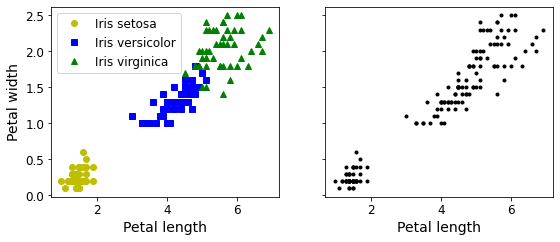

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Let's map each cluster to a class. Instead of hard coding the mapping, we will pick the most common class for each cluster (using the `scipy.stats.mode()` function):

In [7]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{1: 0, 2: 1, 0: 2}

In [8]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

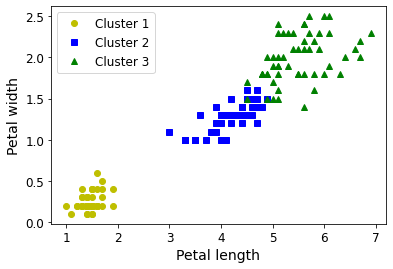

In [9]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

Let's look at the accuracy:

In [11]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

Clustering can be used in these fields:

- For customer segmentation
- For data analysis
- As a dimensionality reduction technique
- For anomaly detection (also called outlier detection)
- For semi-supervised learning
- For search engines
- To segment an image

There is no universal definition of what a cluster is: it really depends on the context, and  different  algorithms  will  capture  different  kinds  of  clusters.  Some  algorithms look  for  instances  centered  around  a  particular  point,  called  a  centroid.  Others  look for  continuous  regions  of  densely  packed  instances:  these  clusters  can  take  on  any shape. Some algorithms are hierarchical, looking for clusters of clusters. And the listgoes on.

In  this  section,  we  will  look  at  two  popular  clustering  algorithms,  K-Means  and DBSCAN,  and  explore  some  of  their  applications,  such  as  nonlinear  dimensionality reduction, semi-supervised learning, and anomaly detection.

### K-Means

Consider  the  unlabeled  dataset  represented  in  Figure  below:  you  can  clearly  see  five blobs of instances. The K-Means algorithm is a simple algorithm capable of clustering this  kind  of  dataset  very  quickly  and  efficiently,  often  in  just  a  few  iterations.  It  was proposed by Stuart Lloyd at Bell Labs in 1957 as a technique for pulse-code modulation, but it was only published outside of the company in 1982.1 In 1965, Edward W.Forgy had published virtually the same algorithm, so K-Means is sometimes referred to as Lloyd–Forgy.

In [19]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [20]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

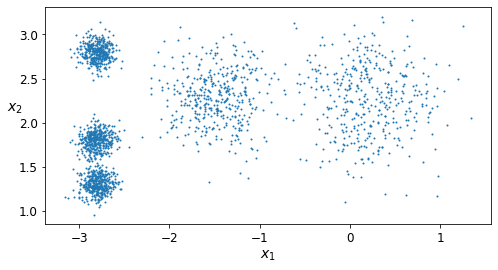

In [21]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

Let’s train a K-Means clusterer on this dataset. It will try to find each blob’s center andassign each instance to the closest blob:

In [31]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Note that you have to specify the number of clusters k that the algorithm must find. In this example, it is pretty obvious from looking at the data that k should be set to 5, but in general it is not that easy. We will discuss this shortly.

Each instance was assigned to one of the five clusters. In the context of clustering, an instance’s  label  is  the  index  of  the  cluster  that  this  instance  gets  assigned  to  by  the algorithm: this is not to be confused with the class labels in classification (rememberthat  clustering  is  an  unsupervised  learning  task).  The  KMeans  instance  preserves  a copy of the labels of the instances it was trained on, available via the labels_ instance variable:

In [32]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [33]:
y_pred is kmeans.labels_

True

We can also take a look at the five centroids that the algorithm found:

In [34]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [35]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

You can easily assign new instances to the cluster whose centroid is closest:

In [37]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

#### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [38]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

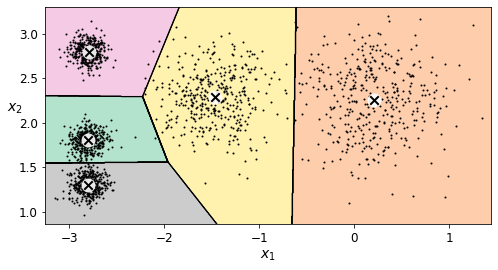

In [39]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

plt.show()

The vast majority of the instances were clearly assigned to the appropriate cluster, buta  few  instances  were  probably  mislabeled  (especially  near  the  boundary  between  the top-left  cluster  and  the  central  cluster).  Indeed,  the  K-Means  algorithm  does  not behave  very  well  when  the  blobs  have  very  different  diameters  because  all  it  caresabout when assigning an instance to a cluster is the distance to the centroid.

Instead of assigning each instance to a single cluster, which is called hard clustering, it can  be  useful  to  give  each  instance  a  score  per  cluster,  which  is  called  soft  clustering. The  score  can  be  the  distance  between  the  instance  and  the  centroid;  conversely,  it can  be  a  similarity  score  (or  affinity),  such  as  the  Gaussian  Radial  Basis  Function.  In  the  KMeans  class,  the  transform()  method  measures the distance from each instance to every centroid:

In [40]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In  this  example,  the  first  instance  in  X_new  is  located  at  a  distance  of  2.81  from  the first centroid, 0.33 from the second centroid, 2.90 from the third centroid, 1.49 fromthe fourth centroid, and 2.89 from the fifth centroid. If you have a high-dimensional dataset and you transform it this way, you end up with a k-dimensional dataset: this transformation can be a very efficient nonlinear dimensionality reduction technique.

### The K-Means Algorithm

So,  how  does  the  algorithm  work?  Well,  suppose  you  were  given  the  centroids.  You could easily label all the instances in the dataset by assigning each of them to the cluster whose centroid is closest. Conversely, if you were given all the instance labels, you could easily locate all the centroids by computing the mean of the instances for each cluster.  But  you  are  given  neither  the  labels  nor  the  centroids,  so  how  can  you  proceed? Well, just start by placing the centroids randomly (e.g., by picking k instances at random  and  using  their  locations  as  centroids).  Then  label  the  instances,  update  the centroids, label the instances, update the centroids, and so on until the centroids stop moving. The algorithm is guaranteed to converge in a finite number of steps (usually quite small); it will not oscillate forever, that’s because the mean squared distance between the instances and their closest centroid can only go down at each step.

You  can  see  the  algorithm  in  action  in  Figure  below:  the  centroids  are  initialized  randomly  (top  left),  then  the  instances  are  labeled  (top  right),  then  the  centroids  are updated (center left), the instances are relabeled (center right), and so on. As you can see, in just three iterations, the algorithm has reached a clustering that seems close to optimal.

The  computational  complexity  of  the  algorithm  is  generally  linear with regard to the number of instances m, the number of clusters k, and  the  number  of  dimensions  n.  However,  this  is  only  true  when the data has a clustering structure. If it does not, then in the worstcase  scenario  the  complexity  can  increase  exponentially  with  the number of instances. In practice, this rarely happens, and K-Means is generally one of the fastest clustering algorithms.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [42]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

Let's plot the image:

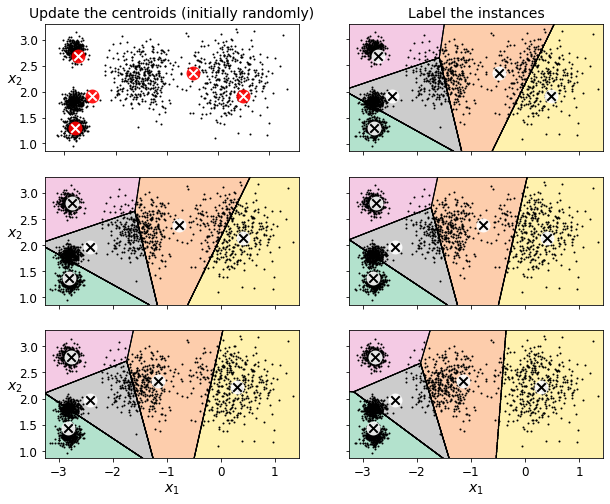

In [44]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

Although  the  algorithm  is  guaranteed  to  converge,  it  may  not  converge  to  the  right solution (i.e., it may converge to a local optimum): whether it does or not depends on the  centroid  initialization.  Figure  below  shows  two  suboptimal  solutions  that  the  algorithm can converge to if you are not lucky with the random initialization step.

In [45]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

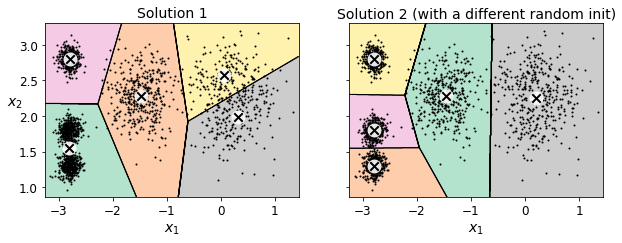

In [48]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

#### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [49]:
kmeans.inertia_

211.59853725816834

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [50]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

In [51]:
kmeans.score(X)

-211.59853725816836

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [52]:
kmeans_rnd_init1.inertia_

219.43539442771407

In [53]:
kmeans_rnd_init2.inertia_

211.59853725816836

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [54]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

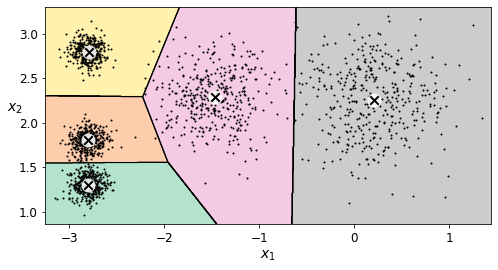

In [56]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### Centroid initializaton methods

If you happen to know approximately where the centroids should be (e.g., if you ran another clustering algorithm earlier), then you can set the init hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1:

In [58]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.59853725816834

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

### Accelerated K-Means and mini-batch K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

Yet  another  important  variant  of  the  K-Means  algorithm  was  proposed  in  a  [2010 paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)  by  David  Sculley.  Instead  of  using  the  full  dataset  at  each  iteration,  the  algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of three or four and makes itpossible  to  cluster  huge  datasets  that  do  not  fit  in  memory.  Scikit-Learn  implements this  algorithm  in  the  MiniBatchKMeans  class.  You  can  just  use  this  class  like  the KMeans class:

In [59]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)
minibatch_kmeans.inertia_

211.65239850433204

If the dataset does not fit in memory, the simplest option is to use the memmap class, as we did for incremental PCA. Alternatively, you can pass one mini-batch at a time to the partial_fit() method, but this will require much more work, since you will need to perform multiple initializations and select the best one yourself.

Let's use MNIST dataset for memmap demonestration.

In [60]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

Next, let's write it to a `memmap`:

In [62]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [63]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

If your data is so large that you cannot use `memmap`, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [64]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [65]:
np.random.seed(42)

k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [66]:
best_kmeans.score(X)

-211.62571878891143

Mini-batch K-Means is much faster than regular K-Means:

In [67]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

47.2 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

22.5 ms ± 5.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Although  the  Mini-batch  K-Means  algorithm  is  much  faster  than  the  regular  K-Means  algorithm,  its  inertia  is  generally  slightly  worse,  especially  as  the  number  of clusters  increases.  You  can  see  this  in  Figure  below:  the  plot  on  the  left  compares  the inertias of Mini-batch K-Means and regular K-Means models trained on the previous dataset  using  various  numbers  of  clusters  k.  The  difference  between  the  two  curves remains  fairly  constant,  but  this  difference  becomes  more  and  more  significant  as  k increases, since the inertia becomes smaller and smaller. In the plot on the right, youcan see that Mini-batch K-Means is much faster than regular K-Means, and this difference increases with k.

In [69]:
from timeit import timeit

times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

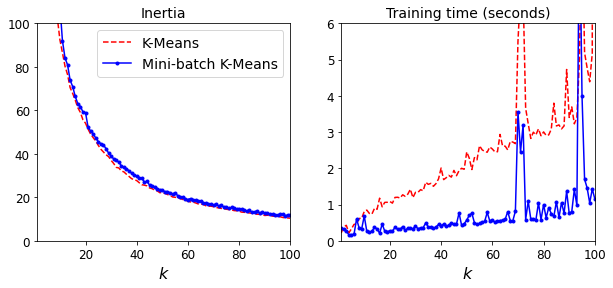

In [71]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

### Finding the optimal number of clusters

So far, we have set the number of clusters k to 5 because it was obvious by looking at the data that this was the correct number of clusters. But in general, it will not be so easy to know how to set k, and the result might be quite bad if you set it to the wrong value. As you can see in Figure below, setting k to 3 or 8 results in fairly bad models.

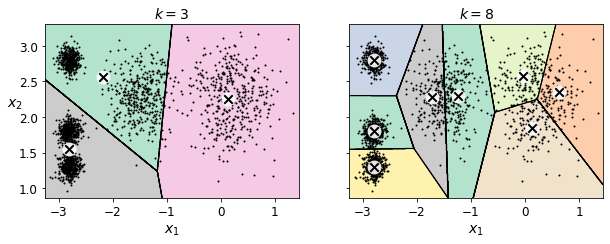

In [74]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

In [75]:
kmeans_k3.inertia_

653.2167190021553

In [76]:
kmeans_k8.inertia_

119.11983416102879

You  might  be  thinking  that  we  could  just  pick  the  model  with  the  lowest  inertia, right? Unfortunately, it is not that simple. The inertia for k=3 is 653.2, which is muchhigher  than  for  k=5  (which  was  211.6).  But  with  k=8,  the  inertia  is  just  119.1.  The inertia  is  not  a  good  performance  metric  when  trying  to  choose  k  because  it  keeps getting  lower  as  we  increase  k.  Indeed,  the  more  clusters  there  are,  the  closer  each instance will be to its closest centroid, and therefore the lower the inertia will be. Let’s plot the inertia as a function of k.

In [77]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

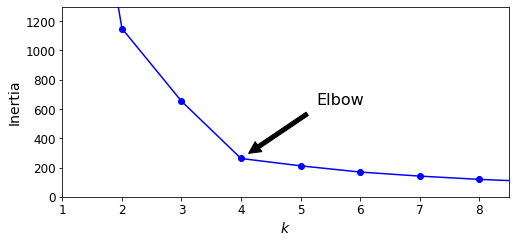

In [79]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])

plt.show()

As  you  can  see,  the  inertia  drops  very  quickly  as  we  increase  k  up  to  4,  but  then  it decreases  much  more  slowly  as  we  keep  increasing  k.  This  curve  has  roughly  the shape  of  an  arm,  and  there  is  an  “elbow”  at  k  =  4.  So,  if  we  did  not  know  better,  4 would  be  a  good  choice:  any  lower  value  would  be  dramatic,  while  any  higher  value would not help much, and we might just be splitting perfectly good clusters in half for no good reason.

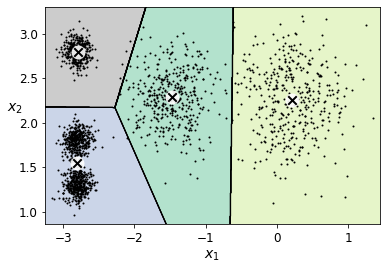

In [80]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

This technique for choosing the best value for the number of clusters is rather coarse. A  more  precise  approach  (but  also  more  computationally  expensive)  is  to  use  the **silhouette  score**,  which  is  the  mean  **silhouette  coefficient**   over  all  the  instances.  An instance’s  silhouette  coefficient  is  equal  to  (b  –  a)  /  max(a,  b),  where  a  is  the  mean distance  to  the  other  instances  in  the  same  cluster  (i.e.,  the  mean  intra-cluster  distance)  and  b  is  the  mean  nearest-cluster  distance  (i.e.,  the  mean  distance  to  the instances  of  the  next  closest  cluster,  defined  as  the  one  that  minimizes  b,  excluding the instance’s own cluster). The silhouette coefficient can vary between –1 and +1. A coefficient  close  to  +1  means  that  the  instance  is  well  inside  its  own  cluster  and  far from  other  clusters,  while  a  coefficient  close  to  0  means  that  it  is  close  to  a  cluster boundary, and finally a coefficient close to –1 means that the instance may have been assigned to the wrong cluster.

To  compute  the  silhouette  score,  you  can  use  Scikit-Learn’s  silhouette_score() function, giving it all the instances in the dataset and the labels they were assigned:

In [81]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

In [82]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

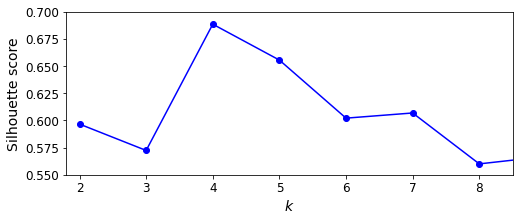

In [84]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

plt.show()

As  you  can  see,  this  visualization  is  much  richer  than  the  previous  one:  although  itconfirms that k = 4 is a very good choice, it also underlines the fact that k = 5 is quitegood as well, and much better than k = 6 or 7. This was not visible when comparing inertias.

An  even  more  informative  visualization  is  obtained  when  you  plot  every  instance’s silhouette coefficient, sorted by the cluster they are assigned to and by the value of thecoefficient.  This  is  called  a  silhouette  diagram  (figure below).  Each  diagram  contains one knife shape per cluster. The shape’s height indicates the number of instances the  cluster  contains,  and  its  width  represents  the  sorted  silhouette  coefficients  of  theinstances  in  the  cluster  (wider  is  better).  The  dashed  line  indicates  the  mean  silhouette coefficient.

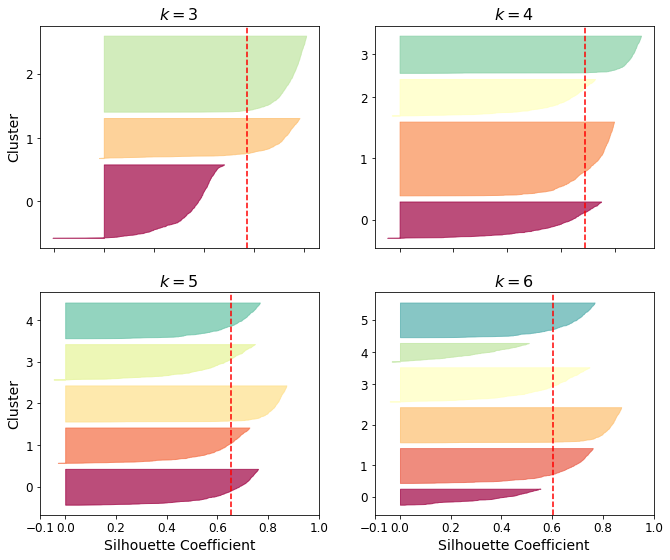

In [85]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

The  vertical  dashed  lines  represent  the  silhouette  score  for  each  number  of  clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster  is  rather  bad  since  this  means  its  instances  are  much  too  close  to  other  clusters. We can see that when k = 3 and when k = 6, we get bad clusters. But when k = 4 or k = 5, the clusters look pretty good: most instances extend beyond the dashed line,to  the  right  and  closer  to  1.0.  When  k  =  4,  the  cluster  at  index  1  (the  third  from  the top)  is  rather  big.  When  k  =  5,  all  clusters  have  similar  sizes.  So,  even  though  the overall  silhouette  score  from  k  =  4  is  slightly  greater  than  for  k  =  5,  it  seems  like  agood idea to use k = 5 to get clusters of similar sizes.